In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from custom_causal_inference import CustomCausalInference
import utils
import forward_models_causal_inference
import matplotlib.pyplot as plt
import pickle

In [2]:
%reload_ext autoreload

In [3]:
D = 250  # grid dimension 
angle_gam_data_path = './base_bayesian_contour_1_circular_gam.pkl'
unif_fn_data_path='./uniform_model_base_inv_kappa_free.pkl'
p_commons = [0, .2, .5, .7, 1]

causal_inference_estimator = forward_models_causal_inference.CausalEstimator(
    model=CustomCausalInference(decision_rule='mean'),
    angle_gam_data_path=angle_gam_data_path,
    unif_fn_data_path=unif_fn_data_path)
unif_map = causal_inference_estimator.unif_map

In [4]:
# optimal_kappa_pairs_filepath = './learned_data/optimal_kappa_pairs_10by10.pkl'
# min_error_for_idx_pc_filepath = './learned_data/min_error_for_idx_pc_10by10.pkl'
# min_error_for_idx_filepath = './learned_data/min_error_for_idx_10by10.pkl'
# s_ns_filepath = './learned_data/selected_s_n_10by10.npy'
# ts_filepath = './learned_data/selected_t_10by10.npy'
# r_ns_filepath = './learned_data/selected_r_n_10by10.npy'
optimal_kappa_pairs_filepath = './learned_data/optimal_kappa_pairs_10by10.pkl'
min_error_for_idx_pc_filepath = './learned_data/min_error_for_idx_pc_10by10.pkl'
min_error_for_idx_filepath = './learned_data/min_error_for_idx_10by10.pkl'
s_ns_filepath = './learned_data/selected_s_n.npy'
ts_filepath = './learned_data/selected_t.npy'
r_ns_filepath = './learned_data/selected_r_n.npy'

In [5]:
with open(optimal_kappa_pairs_filepath, 'rb') as f:
    optimal_kappa_pairs = pickle.load(f)
with open(min_error_for_idx_pc_filepath, 'rb') as f:
    min_error_for_idx_pc = pickle.load(f)
with open(min_error_for_idx_filepath, 'rb') as f:
    min_error_for_idx = pickle.load(f)
s_ns = np.load(s_ns_filepath)
ts = np.load(ts_filepath)
r_ns = np.load(r_ns_filepath)

In [11]:
grid_dim = int(np.sqrt(s_ns.shape[0]))
grid_dim

3

Indices in grid of selected stimuli: [ 62  97 111 122]
Indices in grid of selected stimuli after wrap test: [ 62  97 111 122]


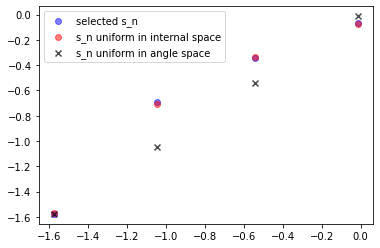

In [21]:
indices = 250//4+utils.select_evenly_spaced_integers(num=4, start=0, end=250//4)
stimuli = np.linspace(-np.pi, np.pi, D)
selected_internal_stimuli = stimuli[indices] # Uniform in internal space
selected_stimuli = unif_map.unif_space_to_angle_space(selected_internal_stimuli)
grid_indices_selected_stimuli = utils.select_closest_values(array=stimuli, 
                                                            selected_values=selected_stimuli, 
                                                            distance_function=utils.circular_dist)
print(f'Indices in grid of selected stimuli: {grid_indices_selected_stimuli}')
if (grid_indices_selected_stimuli[0] == 0) and (grid_indices_selected_stimuli[-1] == 0):
    grid_indices_selected_stimuli[-1] = D-1
grid_indices_selected_stimuli = np.sort(grid_indices_selected_stimuli)
print(f'Indices in grid of selected stimuli after wrap test: {grid_indices_selected_stimuli}')
plt.scatter(selected_internal_stimuli, stimuli[grid_indices_selected_stimuli], label='selected s_n', alpha=.5, c='b')
plt.scatter(selected_internal_stimuli, selected_stimuli, label='s_n uniform in internal space', alpha=.5, c='r')
plt.scatter(selected_internal_stimuli, selected_internal_stimuli, alpha=.7, c='k', marker='x', label='s_n uniform in angle space')
plt.legend()
plt.show()
grid_indices_selected_stimuli = np.unique(grid_indices_selected_stimuli)
r_ns = causal_inference_estimator.gam_data['full_pdf_mat'][grid_indices_selected_stimuli, :, 2]
r_ns = r_ns[:, grid_indices_selected_stimuli]
ts, s_ns = np.meshgrid(stimuli[grid_indices_selected_stimuli], 
                        stimuli[grid_indices_selected_stimuli], indexing='ij')
r_ns, s_ns, ts = r_ns.flatten(), s_ns.flatten(), ts.flatten()

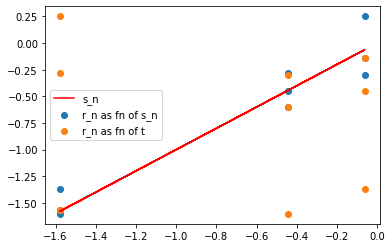

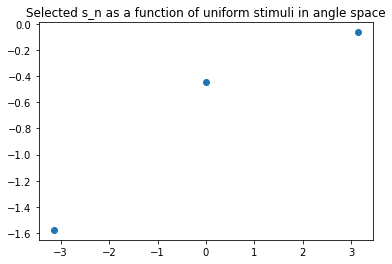

In [12]:
plt.scatter(s_ns, r_ns, label = 'r_n as fn of s_n')
plt.scatter(ts, r_ns, label='r_n as fn of t')
plt.plot(s_ns, s_ns, label='s_n', c='r')
plt.legend()
plt.show()
plt.scatter(np.linspace(-np.pi, np.pi, num=grid_dim), s_ns[:grid_dim])
plt.title('Selected s_n as a function of uniform stimuli in angle space')
plt.show()

In [ ]:
err_mat = np.zeros_like(s_ns)
optimal_kappa_pairs_arr = np.zeros((*s_ns.shape, 2))
optimal_pc = np.zeros_like(s_ns)
for key in min_error_for_idx_pc:
    if min_error_for_idx_pc[key] == min_error_for_idx[key[0]]:
        optimal_pc[key[0]] = key[1]
        err_mat[int(key[0])] = min_error_for_idx[key[0]]
        optimal_kappa_pairs_arr[int(key[0]), :] = np.array(optimal_kappa_pairs[key]).reshape(2,)
        print(f'{key[0]}: t, s_n, r_n = {np.round(s_ns[key[0]], 3), np.round(ts[key[0]], 3), np.round(r_ns[key[0]], 4)}, d/pi={np.round(utils.circular_dist(s_ns[key[0]], ts[key[0]]) / np.pi, 4)}, min_err={min_error_for_idx_pc[key]},  p_c={np.round(key[1], 3)}, optimal_kappa={optimal_kappa_pairs[key]}')

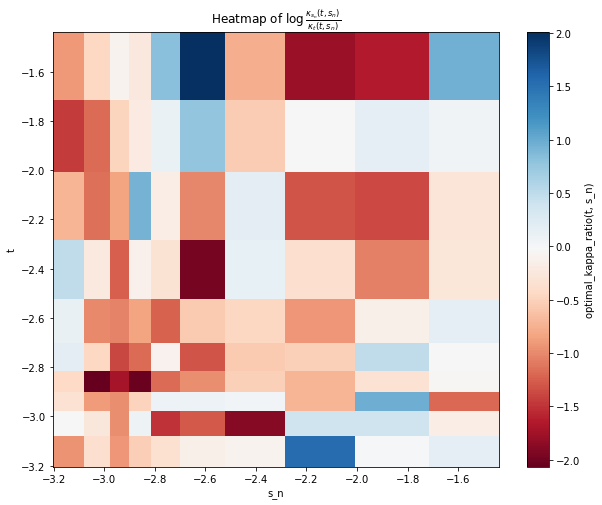

In [23]:
optimal_kappa_ratio = optimal_kappa_pairs_arr[:, 1] / optimal_kappa_pairs_arr[:, 0]
plt.figure(figsize=(10, 8))
plt.pcolormesh(s_ns.reshape((grid_dim, grid_dim)), ts.reshape((grid_dim, grid_dim)), 
               np.log10(optimal_kappa_ratio.reshape((grid_dim, grid_dim))), shading='auto', cmap='RdBu')
plt.colorbar(label='optimal_kappa_ratio(t, s_n)')
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of $\log{\\frac{\kappa_{s_n}(t, s_n)}{\kappa_{t}(t, s_n)}}$')
plt.show()

In [10]:
optimal_kappa_pairs_arr[optimal_kappa_pairs_arr[:, 0] <= optimal_kappa_pairs_arr[:, 1]]

array([[  2.11542767,  72.78439604],
       [  2.91645006,   4.28422566],
       [  1.30681357,   1.54529927],
       [  3.61264638,   8.94778384],
       [  4.24183367,  10.60536062],
       [  1.11297512,   1.37976766],
       [  1.11297512,   1.37976766],
       [  1.30681357,   1.4601897 ],
       [  5.84803548,  54.83043459],
       [  2.35441836,   3.61461779],
       [ 49.74152406, 152.01324437],
       [  1.05497636,   1.37976766],
       [  4.47503424,   6.74060517],
       [ 11.11533933,  34.84938651],
       [  1.11297512,   1.54529927],
       [  1.30681357,  11.22351159],
       [  2.23172618,   3.41553754],
       [189.57770805, 239.17070251],
       [ 47.14942063, 283.47707037],
       [  1.17416243,   1.73068981],
       [  2.35441836,   2.72298838],
       [ 44.69239549, 300.        ],
       [  2.76446959, 283.47707037],
       [  2.48385571,  22.14973762]])

In [33]:
s_ns.reshape((10,10))[0], ts.reshape((10, 10))[0]

(array([-3.14159265, -3.01542427, -2.93972325, -2.86402222, -2.76308751,
        -2.63691913, -2.40981605, -2.15747929, -1.85467518, -1.57710475]),
 array([-3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265,
        -3.14159265, -3.14159265, -3.14159265, -3.14159265, -3.14159265]))

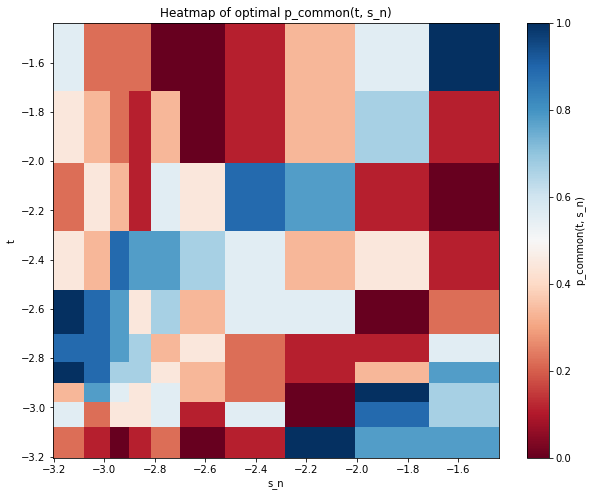

In [ ]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(s_ns.reshape((grid_dim, grid_dim)), ts.reshape((grid_dim, grid_dim)), 
               optimal_pc.reshape((grid_dim, grid_dim)), shading='auto', cmap='RdBu')
plt.colorbar(label='p_common(t, s_n)')
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of optimal p_common(t, s_n)')
plt.show()

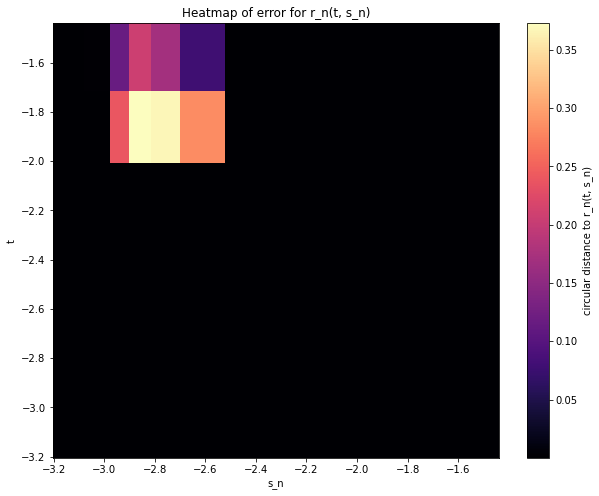

In [25]:
plt.figure(figsize=(10, 8))
plt.pcolormesh(s_ns.reshape((grid_dim, grid_dim)), ts.reshape((grid_dim, grid_dim)), 
               err_mat.reshape((grid_dim, grid_dim)), shading='auto', cmap='magma')
plt.colorbar(label='circular distance to r_n(t, s_n)')
plt.xlabel('s_n')
plt.ylabel('t')
plt.title('Heatmap of error for r_n(t, s_n)')
plt.show()

## Looking at optimal $\kappa$ pairs

In [23]:
dicts = []
lens = []
num_tasks = 90

with open (f'./learned_data/task_metadata.pkl', 'rb') as f:
    tasks_metadata = pickle.load(f)

for i in range(90):
    with open (f'./learned_data/errors_dict_{i}.pkl', 'rb') as f:
        errors_dict = pickle.load(f)
    dicts.append(errors_dict)
    lens.append(errors_dict['errors'].shape)
print('Number of values saved per task', lens)
task_idxs = [2430, 3163]
for task_idx in task_idxs:
    print(f'Otimal kappas for the {task_idx}-th task:{dicts[0]["optimal_kappa1"], dicts[0]["optimal_kappa2"]}')
    print(f'Task {task_idx} metadata: {tasks_metadata[task_idx]}')
    mean_indices = tasks_metadata[task_idx]["mean_indices"]
    print(f'Selected values: s_n t, r_n: {s_ns[mean_indices], ts[mean_indices], r_ns[mean_indices]}')

Number of values saved per task [(50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (34,), (33,), (31,), (30,), (30,), (31,), (29,), (27,), (27,), (14,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (35,), (8,), (9,), (8,), (6,), (7,), (4,), (5,), (50,), (2,), (5,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (50,), (3,), (5,), (30,), (50,), (2,), (6,), (6,), (9,), (4,), (3,), (3,), (8,), (5,), (9,), (16,), (25,), (11,), (4,), (4,), (3,), (2,), (2,), (50,), (6,), (9,), (6,), (7,), (6,), (7,), (6,), (5,), (7,), (6,)]
Otimal kappas for the 2430-th task:(array([ 10.5361, 200.    ,  61.6155,   1.8016, 111.0095,  34.1995,
        18.9824,  34.1995,   3.2459,   3.2459,  18.9824,  61.6155,
        34.1995,  18.9824,   1.8016, 200.    ,  18.9824, 111.0095,
        61.6155,   5.848 ,   3.2459,   5.848 ,   1.8016,  10.5361,
       111.0095, 200.    ,  18.9824,   1.8016, 200.    ,   1.8016,
  